## 문제출제 목적
- 내부요인(상품력, 시즌별 상품변화) + 외부요인(날씨,이슈,시청률) 을 통해 프로그램 매출 실적을 사전에 예측하고 대응

### 데이터 설명
- 판매가 0원(무형, 보험 상품)은 추정 제외
- 매주 토요일 18:00 ~ 18:20은 제외(이미 제외되어 있음)
- 편성시간은 10~60분 내외
- 편성표는 6:20~2:20(익일)으로 구성(심야시간대 제외)
- 취급액 = 판매단가 * 주문량

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime 
import locale                                                           
import re

from tqdm import tqdm_notebook,tqdm,notebook
import matplotlib.pylab as plt
import json
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)
locale.setlocale(locale.LC_ALL, 'ko_KR.UTF-8') 

'ko_KR.UTF-8'

## **데이터 load 및 간단한 처리**

In [2]:
file_root = '../2020빅콘테스트 문제데이터(데이터분석분야-챔피언리그)_update_200818/01_제공데이터/'
performance_data = pd.read_excel(file_root+'2020 빅콘테스트 데이터분석분야-챔피언리그_2019년 실적데이터_v1_200818.xlsx',header=1)
rating_data = pd.read_excel(file_root+'2020 빅콘테스트 데이터분석분야-챔피언리그_시청률 데이터.xlsx',header=1)
test_data = pd.read_excel('../2020빅콘테스트 문제데이터(데이터분석분야-챔피언리그)_update_200818/02_평가데이터/2020 빅콘테스트 데이터분석분야-챔피언리그_2020년 6월 판매실적예측데이터(평가데이터).xlsx',header=1)

In [4]:
day = int(input("6월 몇일의 편성표를 만들까요? : "))

6월 몇일의 편성표를 만들까요? :  1


In [5]:
start = test_data['방송일시'][0]+datetime.timedelta(days=(day-1))
start_time = start

In [6]:
start_time

Timestamp('2020-06-01 06:20:00')

In [7]:
time_list = []
for idx,j in enumerate([start_time]):
    for i in range(60):  # 하루에 나눌수 있는 시간, 20분 단위로 60개 
        if i == 0:
            #print(i)
            #print(j)
            time_list.append(j + datetime.timedelta(minutes=20))
            
        else  :
            #print(idx)
            time_list.append(time_list[idx*60+i-1]+ datetime.timedelta(minutes=20))
# print(time_list)

In [8]:
time = pd.DataFrame(time_list, columns = ['방송일시'])
time['on'] = 0
test_data= test_data[['노출(분)', '마더코드', '상품코드', '상품명', '상품군', '판매단가', '취급액']]
test_data = test_data.loc[test_data['상품코드'].drop_duplicates().index]
test_data = test_data.reset_index().drop(['index'],axis=1)
test_data['on']=0
test_data = test_data.merge(time,how='left', on = 'on')

In [9]:
display(performance_data.head())
display(rating_data.head())
display(test_data.head())

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액
0,2019-01-01 06:00:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000.0
1,2019-01-01 06:00:00,NaN,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000.0
2,2019-01-01 06:20:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,3262000.0
3,2019-01-01 06:20:00,NaN,100346,201079,테이트 여성 셀린니트3종,의류,39900,6955000.0
4,2019-01-01 06:40:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,6672000.0


,시간대,2019-01-01,2019-01-02,2019-01-03,2019-01-04,2019-01-05,2019-01-06,2019-01-07,2019-01-08,2019-01-09,...,2019-12-23,2019-12-24,2019-12-25,2019-12-26,2019-12-27,2019-12-28,2019-12-29,2019-12-30,2019-12-31,2019-01-01 to 2019-12-31
0,02:00,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.003
1,02:01,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.012,0.003
2,02:02,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.004
3,02:03,0.0,0.0,0.014,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.017,0.0,0.0,0.0,0.0,0.0,0.000,0.004
4,02:04,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.017,0.0,0.0,0.0,0.0,0.0,0.000,0.004


,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,on,방송일시
0,20.0,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,NaN,0,2020-06-01 06:40:00
1,20.0,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,NaN,0,2020-06-01 07:00:00
2,20.0,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,NaN,0,2020-06-01 07:20:00
3,20.0,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,NaN,0,2020-06-01 07:40:00
4,20.0,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,NaN,0,2020-06-01 08:00:00


### **간단한 전처리**

In [10]:
# 판매단가가 0, 취급액이 결측치인 데이터는 처음부터 제외하고 진행
performance_data = performance_data[performance_data.판매단가 != 0].reset_index(drop=True)
performance_data = performance_data[performance_data.취급액.isnull()==False].reset_index(drop=True)
test_data = test_data[test_data.판매단가 != 0].reset_index(drop=True)
test_data['취급액'] = -1

In [11]:
performance_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35379 entries, 0 to 35378
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   방송일시    35379 non-null  datetime64[ns]
 1   노출(분)   20403 non-null  float64       
 2   마더코드    35379 non-null  int64         
 3   상품코드    35379 non-null  int64         
 4   상품명     35379 non-null  object        
 5   상품군     35379 non-null  object        
 6   판매단가    35379 non-null  int64         
 7   취급액     35379 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 2.2+ MB


In [12]:
performance_data['노출(분)'] = performance_data['노출(분)'].fillna(method='ffill')
test_data['노출(분)'] = test_data['노출(분)'].fillna(method='ffill')

In [13]:
performance_data['마더코드'] = performance_data['마더코드'].map(str)
performance_data['상품코드'] = performance_data['상품코드'].map(str)

test_data['마더코드'] = test_data['마더코드'].map(str)
test_data['상품코드'] = test_data['상품코드'].map(str)

In [14]:
# 판매량 생성
performance_data['판매량'] = performance_data.취급액/performance_data.판매단가
test_data['판매량'] = -1
performance_data.head()

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,판매량
0,2019-01-01 06:00:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000.0,52.606516
1,2019-01-01 06:00:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000.0,109.548872
2,2019-01-01 06:20:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,3262000.0,81.754386
3,2019-01-01 06:20:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,6955000.0,174.310777
4,2019-01-01 06:40:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,6672000.0,167.218045


In [15]:
performance_data.describe()

,노출(분),판매단가,취급액,판매량
count,35379.000000,3.537900e+04,3.537900e+04,35379.000000
mean,20.335035,3.878590e+05,2.310241e+07,314.797301
std,3.095697,6.264088e+05,2.005790e+07,427.826506
min,2.466667,1.280000e+04,1.030000e+05,1.302349
25%,20.000000,5.900000e+04,7.998500e+06,26.283654
50%,20.000000,9.900000e+04,1.732600e+07,130.000000
75%,20.000000,3.990000e+05,3.276300e+07,451.719941
max,40.000000,7.930000e+06,3.220090e+08,8070.401003


In [16]:
print('마더코드 수 :',performance_data.마더코드.nunique())
print('상품코드 수 :',performance_data.상품코드.nunique())
print('상품명 수 :',performance_data.상품명.nunique())
print('상품군 수 :',performance_data.상품군.nunique())

마더코드 수 : 687
상품코드 수 : 2031
상품명 수 : 1682
상품군 수 : 11


### **기본 feature 생성**

#### **요일 생성**

In [17]:
def date2day(x):
    d = datetime.date(x.year, x.month, x.day) 
    x = d.strftime('%A')
    return x
performance_data['요일'] = performance_data.방송일시.apply(lambda x: date2day(x))
test_data['요일'] = test_data.방송일시.apply(lambda x: date2day(x))
performance_data.head()

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,판매량,요일
0,2019-01-01 06:00:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000.0,52.606516,화요일
1,2019-01-01 06:00:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000.0,109.548872,화요일
2,2019-01-01 06:20:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,3262000.0,81.754386,화요일
3,2019-01-01 06:20:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,6955000.0,174.310777,화요일
4,2019-01-01 06:40:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,6672000.0,167.218045,화요일


#### **시간변수 생성**

In [18]:
performance_data['hour'] = performance_data.방송일시.apply(lambda x: x.hour)
performance_data['minute'] = performance_data.방송일시.apply(lambda x: x.minute)
performance_data['date'] = performance_data.방송일시.astype(str).apply(lambda x: x.split(' ')[0])
performance_data['month'] = performance_data.방송일시.apply(lambda x: x.month)

test_data['hour'] = test_data.방송일시.apply(lambda x: x.hour)
test_data['minute'] = test_data.방송일시.apply(lambda x: x.minute)
test_data['date'] = test_data.방송일시.astype(str).apply(lambda x: x.split(' ')[0])
test_data['month'] = test_data.방송일시.apply(lambda x: x.month)

##### **계절**

In [19]:
def make_season(x):
    if 3 <= x <= 5 :
        return('봄')
    elif 6 <= x <= 8 :
        return('여름')
    elif 9 <= x <= 11 :    
        return('가을')
    else :
        return('겨울')  
performance_data['season'] = performance_data.month.apply(lambda x: make_season(x))
test_data['season'] = test_data.month.apply(lambda x: make_season(x))
performance_data.head()

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,판매량,요일,hour,minute,date,month,season
0,2019-01-01 06:00:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000.0,52.606516,화요일,6,0,2019-01-01,1,겨울
1,2019-01-01 06:00:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000.0,109.548872,화요일,6,0,2019-01-01,1,겨울
2,2019-01-01 06:20:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,3262000.0,81.754386,화요일,6,20,2019-01-01,1,겨울
3,2019-01-01 06:20:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,6955000.0,174.310777,화요일,6,20,2019-01-01,1,겨울
4,2019-01-01 06:40:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,6672000.0,167.218045,화요일,6,40,2019-01-01,1,겨울


#### **시청률 합치기**

In [20]:
rating_data = rating_data.iloc[:-1,:]

In [21]:
rating_data['hour'] = rating_data.시간대.apply(lambda x: x.split(':')[0])
rating_data['minute'] = rating_data.시간대.apply(lambda x: x.split(':')[1])
rating_data.hour = rating_data.hour.map(int)
rating_data.minute = rating_data.minute.map(int)

In [22]:
merge_data = performance_data.drop_duplicates(['date','hour','minute']).reset_index(drop=True)
merge_data['subMin'] = merge_data.loc[1:,'방송일시'].reset_index(drop=True) - merge_data.loc[:20586,'방송일시']
merge_data['subMin'] = merge_data['subMin'].apply(lambda x: x.seconds/60)
merge_data = merge_data.iloc[:-1,:] # 2020년 데이터, 시청률 없음.

In [23]:
# max_rating = []
# for i in tqdm(range(len(merge_data))):
#     hour = merge_data.hour[i]
#     minute = merge_data.minute[i]
#     idx = rating_data[(rating_data.hour == hour) & (rating_data.minute == minute)].index[0]
#     a = rating_data.iloc[idx:int(idx+merge_data.subMin[i]),:]
#     max_rating.append(a[merge_data.date[i]].max())

mean_rating = []
for i in tqdm(range(len(merge_data))):
    hour = merge_data.hour[i]
    minute = merge_data.minute[i]
    idx = rating_data[(rating_data.hour == hour) & (rating_data.minute == minute)].index[0]
    
    a = rating_data.iloc[idx:int(idx+merge_data.subMin[i]),:]
    mean_rating.append(a[merge_data.date[i]].mean())

# merge_data['max_rating'] = max_rating
merge_data['mean_rating'] = mean_rating

merge_data = merge_data[['방송일시','mean_rating']]
performance_data = performance_data.merge(merge_data,on='방송일시',how='left')
performance_data.head()

100%|██████████| 20565/20565 [00:17<00:00, 1144.25it/s]


,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,판매량,요일,hour,minute,date,month,season,mean_rating
0,2019-01-01 06:00:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000.0,52.606516,화요일,6,0,2019-01-01,1,겨울,0.0
1,2019-01-01 06:00:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000.0,109.548872,화요일,6,0,2019-01-01,1,겨울,0.0
2,2019-01-01 06:20:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,3262000.0,81.754386,화요일,6,20,2019-01-01,1,겨울,0.0
3,2019-01-01 06:20:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,6955000.0,174.310777,화요일,6,20,2019-01-01,1,겨울,0.0
4,2019-01-01 06:40:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,6672000.0,167.218045,화요일,6,40,2019-01-01,1,겨울,0.0


In [24]:
performance_data['mean_rating'] = performance_data['mean_rating'].fillna(method='ffill')

#### **공휴일 붙이기**

In [25]:
with open('../data/holiday.json', 'r') as f:
    holiday = json.load(f)
holiday = {v: k for k, v in holiday.items()}
holiday

{'20190101': '1월1일_2019_0',
 '20190204': '설날_2019_0',
 '20190205': '설날_2019_1',
 '20190206': '설날_2019_2',
 '20190301': '삼일절_2019_0',
 '20190505': '어린이날_2019_0',
 '20190506': '대체공휴일_2019_1',
 '20190512': '부처님오신날_2019_2',
 '20190606': '현충일_2019_0',
 '20190815': '광복절_2019_0',
 '20190912': '추석_2019_0',
 '20190913': '추석_2019_1',
 '20190914': '추석_2019_2',
 '20191003': '개천절_2019_0',
 '20191009': '한글날_2019_1',
 '20191225': '기독탄신일_2019_0',
 '20200101': '1월1일_2020_0',
 '20200124': '설날_2020_1',
 '20200125': '설날_2020_2',
 '20200126': '설날_2020_3',
 '20200127': '설날_2020_4',
 '20200301': '삼일절_2020_0',
 '20200415': '제21대 국회의원선거_2020_0',
 '20200430': '부처님오신날_2020_1',
 '20200505': '어린이날_2020_0',
 '20200606': '현충일_2020_0'}

In [26]:
keys = list(holiday.keys())
for i in keys:
    holiday[i] = holiday[i][:-7]
holiday

{'20190101': '1월1일',
 '20190204': '설날',
 '20190205': '설날',
 '20190206': '설날',
 '20190301': '삼일절',
 '20190505': '어린이날',
 '20190506': '대체공휴일',
 '20190512': '부처님오신날',
 '20190606': '현충일',
 '20190815': '광복절',
 '20190912': '추석',
 '20190913': '추석',
 '20190914': '추석',
 '20191003': '개천절',
 '20191009': '한글날',
 '20191225': '기독탄신일',
 '20200101': '1월1일',
 '20200124': '설날',
 '20200125': '설날',
 '20200126': '설날',
 '20200127': '설날',
 '20200301': '삼일절',
 '20200415': '제21대 국회의원선거',
 '20200430': '부처님오신날',
 '20200505': '어린이날',
 '20200606': '현충일'}

In [27]:
def func(x):
    if x in holiday:
        x = holiday[x]
    else:
        x = np.nan
    return x
performance_data.date = performance_data.date.apply(lambda x: re.sub('-','',x))
performance_data['holiday'] = performance_data.date.apply(lambda x: func(x))
test_data.date = test_data.date.apply(lambda x: re.sub('-','',x))
test_data['holiday'] = test_data.date.apply(lambda x: func(x))
performance_data.head()

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,판매량,요일,hour,minute,date,month,season,mean_rating,holiday
0,2019-01-01 06:00:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000.0,52.606516,화요일,6,0,20190101,1,겨울,0.0,1월1일
1,2019-01-01 06:00:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000.0,109.548872,화요일,6,0,20190101,1,겨울,0.0,1월1일
2,2019-01-01 06:20:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,3262000.0,81.754386,화요일,6,20,20190101,1,겨울,0.0,1월1일
3,2019-01-01 06:20:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,6955000.0,174.310777,화요일,6,20,20190101,1,겨울,0.0,1월1일
4,2019-01-01 06:40:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,6672000.0,167.218045,화요일,6,40,20190101,1,겨울,0.0,1월1일


In [28]:
performance_data.holiday.value_counts()

추석        296
설날        289
한글날       132
개천절       124
대체공휴일     120
현충일       117
부처님오신날    117
어린이날      110
삼일절       110
광복절       106
기독탄신일      89
1월1일       62
Name: holiday, dtype: int64

In [29]:
null_idx = performance_data[performance_data.holiday.isnull()].index
non_null_idx = performance_data[performance_data.holiday.isnull()==False].index
performance_data['holiday_yn'] = performance_data.holiday
performance_data.loc[null_idx,'holiday_yn'] = 0
performance_data.loc[non_null_idx,'holiday_yn'] = 1

weekend_idx = performance_data[performance_data.요일.isin(['토요일','일요일'])].index
performance_data.loc[weekend_idx,'holiday_yn'] = 1


null_idx = test_data[test_data.holiday.isnull()].index
non_null_idx = test_data[test_data.holiday.isnull()==False].index
test_data['holiday_yn'] = test_data.holiday
test_data.loc[null_idx,'holiday_yn'] = 0
test_data.loc[non_null_idx,'holiday_yn'] = 1

weekend_idx = test_data[test_data.요일.isin(['토요일','일요일'])].index
test_data.loc[weekend_idx,'holiday_yn'] = 1

### **테스트 데이터 시청률 채우기**

In [30]:
plot_data = performance_data[performance_data.mean_rating != -1].reset_index(drop=True)

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.
/home/han811/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50900 missing from current font.
  font.set_text(s, 0.0, flags=flags)
findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.
/home/han811/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 50900 missing from current font.
  font.set_text(s, 0, flags=flags)


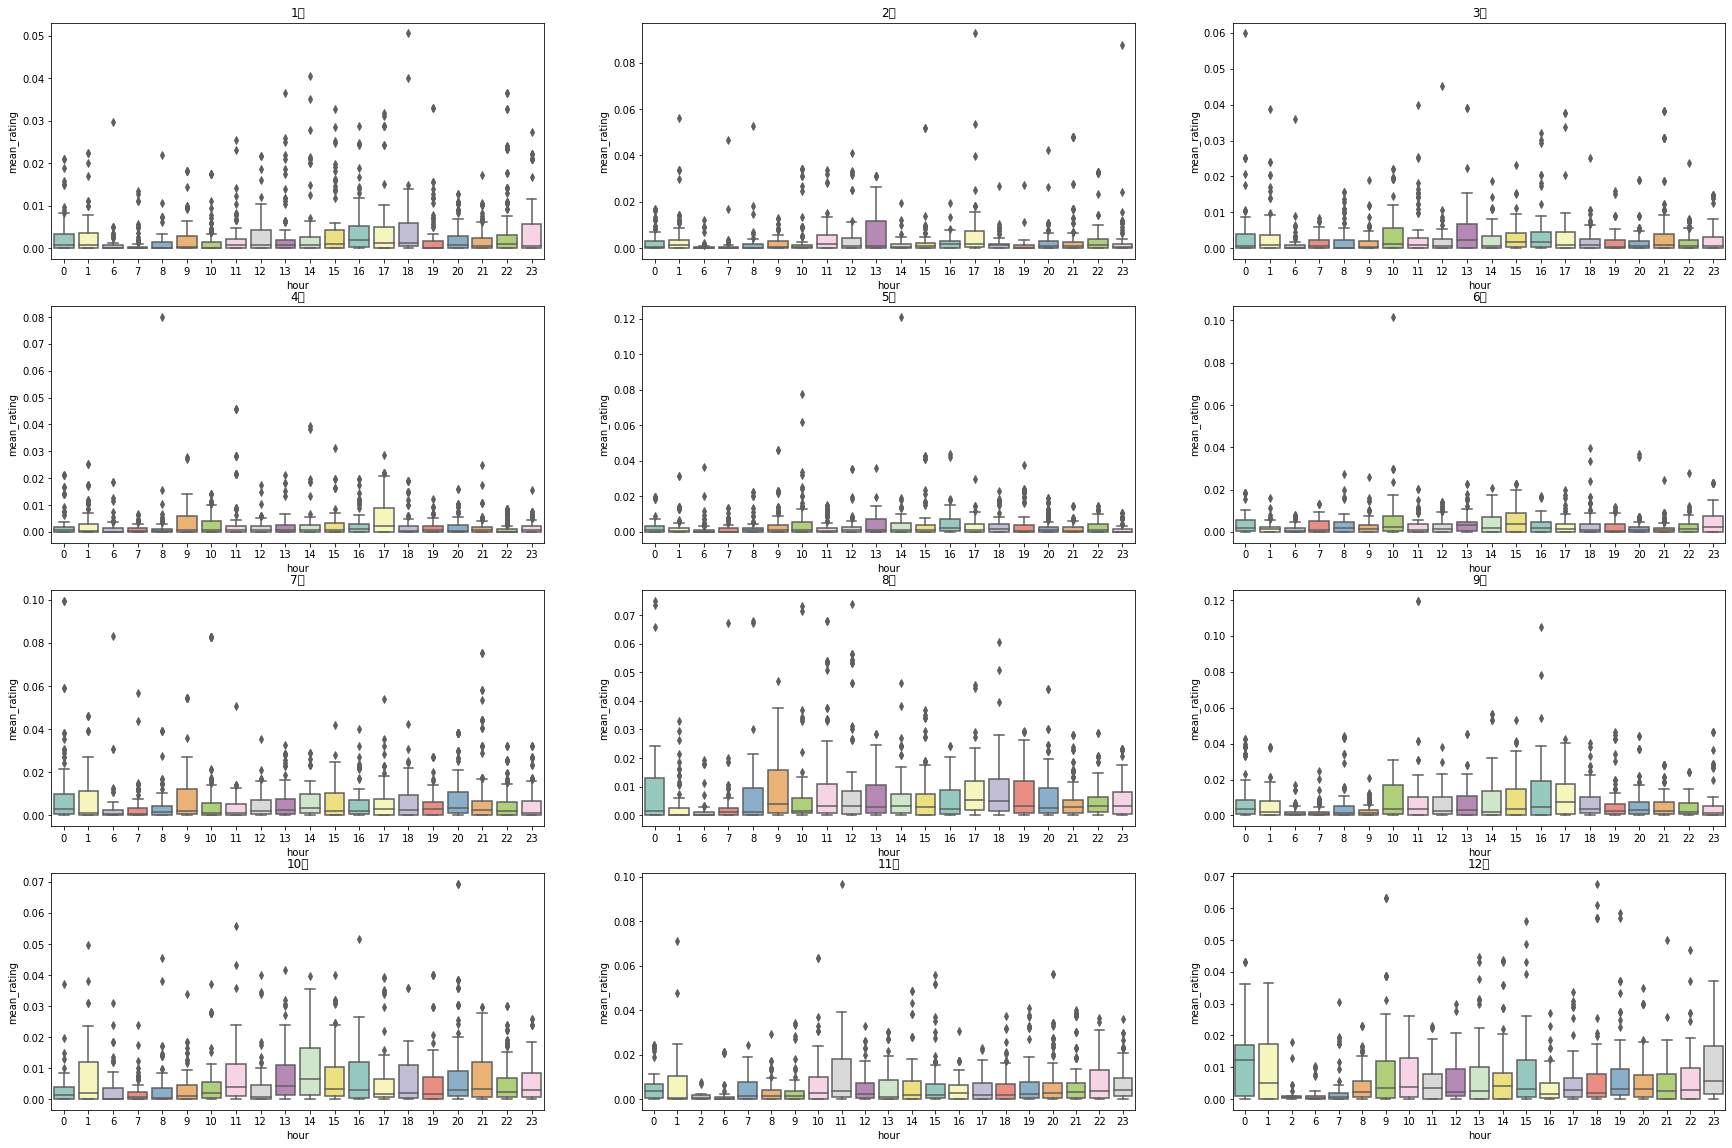

In [31]:
figure, ((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9),(ax10,ax11,ax12)) = plt.subplots(nrows=4, ncols=3)
figure.set_size_inches(30,20)
plt.title('월별 시간대별 시청률')
ax1.set_title('1월')
ax2.set_title('2월')
ax3.set_title('3월')
ax4.set_title('4월')
ax5.set_title('5월')
ax6.set_title('6월')
ax7.set_title('7월')
ax8.set_title('8월')
ax9.set_title('9월')
ax10.set_title('10월')
ax11.set_title('11월')
ax12.set_title('12월')
sns.boxplot(x = "hour", y = "mean_rating", data = plot_data[(plot_data.month==1) & (plot_data.holiday_yn==0)], palette = "Set3",ax=ax1)
sns.boxplot(x = "hour", y = "mean_rating", data = plot_data[(plot_data.month==2)& (plot_data.holiday_yn==0)], palette = "Set3",ax=ax2)
sns.boxplot(x = "hour", y = "mean_rating", data = plot_data[(plot_data.month==3)& (plot_data.holiday_yn==0)], palette = "Set3",ax=ax3)
sns.boxplot(x = "hour", y = "mean_rating", data = plot_data[(plot_data.month==4)& (plot_data.holiday_yn==0)], palette = "Set3",ax=ax4)
sns.boxplot(x = "hour", y = "mean_rating", data = plot_data[(plot_data.month==5)& (plot_data.holiday_yn==0)], palette = "Set3",ax=ax5)
sns.boxplot(x = "hour", y = "mean_rating", data = plot_data[(plot_data.month==6)& (plot_data.holiday_yn==0)], palette = "Set3",ax=ax6)
sns.boxplot(x = "hour", y = "mean_rating", data = plot_data[(plot_data.month==7)& (plot_data.holiday_yn==0)], palette = "Set3",ax=ax7)
sns.boxplot(x = "hour", y = "mean_rating", data = plot_data[(plot_data.month==8)& (plot_data.holiday_yn==0)], palette = "Set3",ax=ax8)
sns.boxplot(x = "hour", y = "mean_rating", data = plot_data[(plot_data.month==9)& (plot_data.holiday_yn==0)], palette = "Set3",ax=ax9)
sns.boxplot(x = "hour", y = "mean_rating", data = plot_data[(plot_data.month==10)& (plot_data.holiday_yn==0)], palette = "Set3",ax=ax10)
sns.boxplot(x = "hour", y = "mean_rating", data = plot_data[(plot_data.month==11)& (plot_data.holiday_yn==0)], palette = "Set3",ax=ax11)
sns.boxplot(x = "hour", y = "mean_rating", data = plot_data[(plot_data.month==12)& (plot_data.holiday_yn==0)], palette = "Set3",ax=ax12)
plt.show()

-> 월별로 시청률이 완전히 상이하다. 시청률을 넣을거면 6월의 일, 시간별 평균 시청률로 넣는것이 바람직할 듯..

In [32]:
mean_06 = performance_data[performance_data.month==6].groupby(['요일','month','hour','minute'])['mean_rating'].mean().reset_index()
test_data = pd.merge(test_data,mean_06,on=['요일','month','hour','minute'],how='left')
test_data['mean_rating'] = test_data['mean_rating'].fillna(method='ffill')
# 일단 2019년 6월의 요일,시간,분 별 평균 시청률로 넣어 주었다.

In [33]:
performance_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35379 entries, 0 to 35378
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   방송일시         35379 non-null  datetime64[ns]
 1   노출(분)        35379 non-null  float64       
 2   마더코드         35379 non-null  object        
 3   상품코드         35379 non-null  object        
 4   상품명          35379 non-null  object        
 5   상품군          35379 non-null  object        
 6   판매단가         35379 non-null  int64         
 7   취급액          35379 non-null  float64       
 8   판매량          35379 non-null  float64       
 9   요일           35379 non-null  object        
 10  hour         35379 non-null  int64         
 11  minute       35379 non-null  int64         
 12  date         35379 non-null  object        
 13  month        35379 non-null  int64         
 14  season       35379 non-null  object        
 15  mean_rating  35379 non-null  float64       
 16  holi

In [34]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23340 entries, 0 to 23339
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   노출(분)        23340 non-null  float64       
 1   마더코드         23340 non-null  object        
 2   상품코드         23340 non-null  object        
 3   상품명          23340 non-null  object        
 4   상품군          23340 non-null  object        
 5   판매단가         23340 non-null  int64         
 6   취급액          23340 non-null  int64         
 7   on           23340 non-null  int64         
 8   방송일시         23340 non-null  datetime64[ns]
 9   판매량          23340 non-null  int64         
 10  요일           23340 non-null  object        
 11  hour         23340 non-null  int64         
 12  minute       23340 non-null  int64         
 13  date         23340 non-null  object        
 14  month        23340 non-null  int64         
 15  season       23340 non-null  object        
 16  holi

In [70]:
performance_data = pd.concat([performance_data,test_data]).reset_index(drop=True)
performance_data['holiday'] = performance_data.holiday.fillna('no_holiday')

In [71]:
performance_data.to_csv('../data/base_data_concat.csv',index=False)